<a href="https://colab.research.google.com/github/krvipin15/Tutorials/blob/main/extras/exercises/02_pytorch_classification_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. PyTorch Classification Exercises

In [1]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup random seed
RANDOM_SEED = 42

## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors.
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [2]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=RANDOM_SEED)
X.shape, y.shape

((1000, 2), (1000,))

In [3]:
# Turn data into a DataFrame
import pandas as pd

data = pd.DataFrame(data={"Feature 1": X[:, 0], "Feature 2": X[:, 1], "Label": y})
data[:5]

,Feature 1,Feature 2,Label
0,-0.021371,0.406186,1
1,0.976700,-0.458323,1
2,0.904059,-0.376520,1
3,0.377363,-0.397037,1
4,-0.841926,0.530587,0


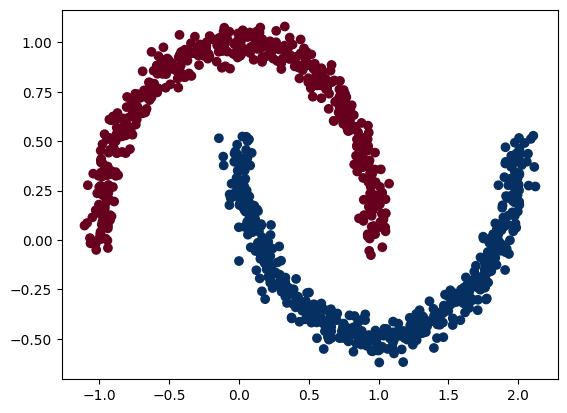

In [4]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdBu);

In [5]:
# Turn data into tensors of dtype float
X = torch.tensor(data=X, dtype=torch.float32, device=device)
y = torch.tensor(data=y, dtype=torch.float32, device=device)


# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [6]:
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(in_features=2, out_features=16),
                                   nn.ReLU(),
                                   nn.Linear(in_features=16, out_features=16),
                                   nn.ReLU(),
                                   nn.Linear(in_features=16, out_features=1))

    def forward(self, x):
        return self.layer(x)

# Instantiate the model
model_0 = MoonModelV0().to(device)
model_0

MoonModelV0(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [7]:
# Setup loss function
loss_func = nn.BCEWithLogitsLoss()

# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [8]:
# What's coming out of our model?

# logits (raw outputs of model)
y_preds = model_0(X_test).squeeze()
print("Logits: ", y_preds[:5])

# Prediction probabilities
y_pred_prob = torch.sigmoid(y_preds)
print("Pred probs: ", y_pred_prob[:5])

# Prediction labels
y_pred_label = torch.round(y_pred_prob)
print("Pred labels: ", y_pred_label[:5])

Logits:  tensor([0.1283, 0.0854, 0.1209, 0.0947, 0.0769], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred probs:  tensor([0.5320, 0.5213, 0.5302, 0.5236, 0.5192], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred labels:  tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SliceBackward0>)


In [9]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
# !pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_func = Accuracy(task="binary", num_classes=2).to(device) # send accuracy function to device
acc_func(y_pred_label, y_test)

tensor(0.5000, device='cuda:0')

In [10]:
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 500

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass (logits output)
  train_logits = model_0(X_train).squeeze()
  # Turn logits into prediction probabilities
  train_pred_prob = torch.sigmoid(input=train_logits)
  # Turn prediction probabilities into prediction labels
  train_pred_label = torch.round(train_pred_prob)

  # 2. Calculaute the loss
  train_loss = loss_func(train_logits, y_train)               # loss = compare model raw outputs to desired model outputs
  # Calculate the accuracy
  train_acc = acc_func(train_pred_label, y_train.int())       # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
  train_loss.backward()

  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    test_logits = model_0(X_test).squeeze()
    # Turn the test logits into prediction labels
    test_pred_label = torch.round(torch.sigmoid(input=test_logits))

    # 2. Caculate the test loss/acc
    test_loss = loss_func(test_logits, y_test)
    test_acc = acc_func(test_pred_label, y_test.int())

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69430, Acc: 0.50% | Test Loss: 0.69080, Test Acc: 0.50%
Epoch: 100 | Loss: 0.31924, Acc: 0.85% | Test Loss: 0.33252, Test Acc: 0.85%
Epoch: 200 | Loss: 0.21251, Acc: 0.89% | Test Loss: 0.21053, Test Acc: 0.91%
Epoch: 300 | Loss: 0.16087, Acc: 0.93% | Test Loss: 0.15679, Test Acc: 0.94%
Epoch: 400 | Loss: 0.11025, Acc: 0.96% | Test Loss: 0.10541, Test Acc: 0.98%


## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [11]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

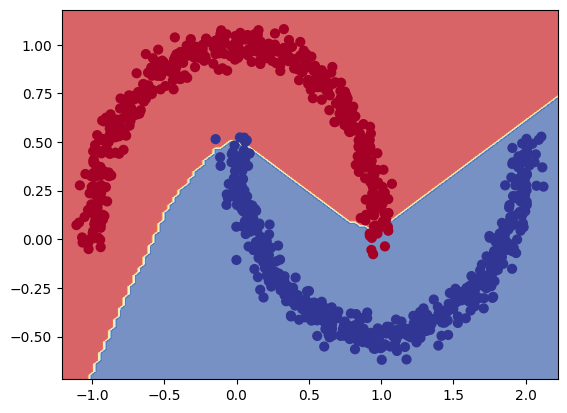

In [12]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model=model_0, X=X, y=y)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

In [26]:
# Create a straight line tensor
line_tensor = torch.arange(-100, 100)
line_tensor[:5]

tensor([-100,  -99,  -98,  -97,  -96])

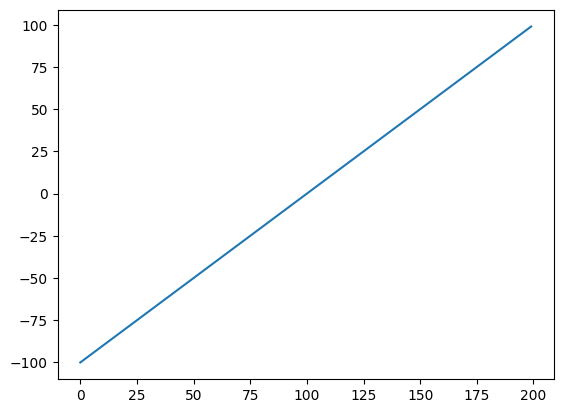

In [30]:
plt.plot(line_tensor.cpu().detach().numpy());

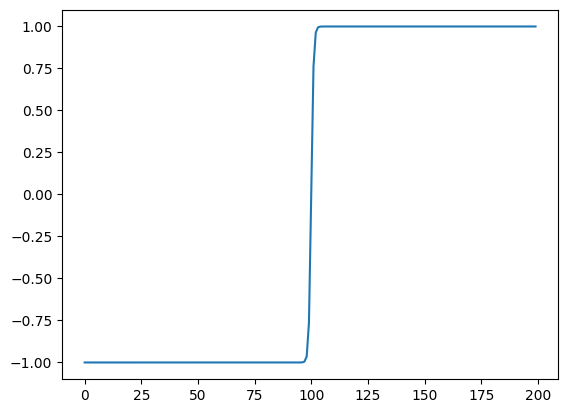

In [31]:
# Test torch.tanh() on the tensor and plot it
plt.plot(torch.tanh(input=line_tensor).detach().numpy());

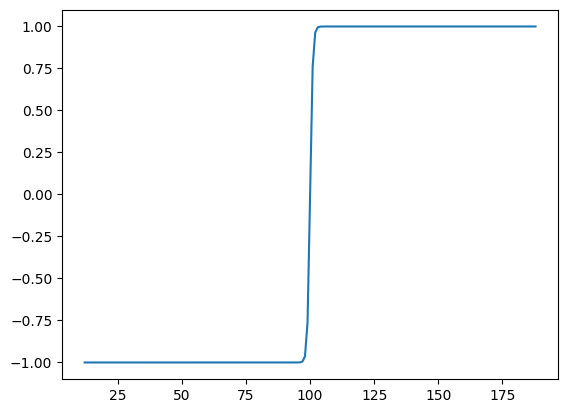

In [33]:
# Replicate torch.tanh() and plot it
def tanh(x):
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(tanh(line_tensor));

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

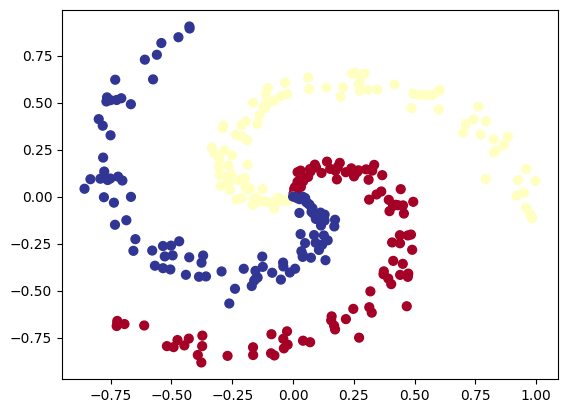

In [34]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100                                                        # number of points per class
D = 2                                                          # dimensionality
K = 3                                                          # number of classes

X = np.zeros((N*K,D))                                          # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8')                               # class labels

for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N)                                     # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2      # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [35]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float).to(device)       # features as float32
y = torch.from_numpy(y).type(torch.LongTensor).to(device)  # labels need to be of type long

# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([240, 2]),
 torch.Size([60, 2]),
 torch.Size([240]),
 torch.Size([60]))

In [36]:
# Let's calculuate the accuracy for when we fit our model
#!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)

In [37]:
# Create model by subclassing nn.Module
class SpiralsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(in_features=2, out_features=16),
                                   nn.ReLU(),
                                   nn.Linear(in_features=16, out_features=16),
                                   nn.ReLU(),
                                   nn.Linear(in_features=16, out_features=1))

    def forward(self, x):
        return self.layer(x)

# Instantiate model and send it to device
model_1 = SpiralsModel().to(device)
model_1

SpiralsModel(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [ ]:
# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
## Your code here ##

print("Pred probs:")
## Your code here ##

print("Pred labels:")
## Your code here ##

In [ ]:
# Setup loss function and optimizer
# loss_fn =
# optimizer =

In [ ]:
# Build a training loop for the model

# Loop over data


  ## Training

  # 1. Forward pass


  # 2. Calculate the loss


  # 3. Optimizer zero grad


  # 4. Loss backward


  # 5. Optimizer step


  ## Testing


    # 1. Forward pass

    # 2. Caculate loss and acc

  # Print out what's happening every 100 epochs


In [ ]:
# Plot decision boundaries for training and test sets
